In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.functions import unix_timestamp, from_unixtime, round
from pyspark.sql.types import StructType, StructField, IntegerType, TimestampType, DoubleType,BooleanType
from pyspark.sql.types import *

spark = SparkSession.builder \
    .appName("read_s3_parquet") \
    .getOrCreate()


storage_account_name = "bia678"
storage_account_access_key = "add_your_key_here"
spark.conf.set(f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net", storage_account_access_key)
container_name = "taxidataset"



df = spark.read.parquet(f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/pavan-bucket/final_dataset_1/part-00000-tid-7859284432058038436-acfb97c2-0415-4be1-9c86-8ac2e04262e7-72183-1-c000.snappy.parquet")
dem = spark.read.csv(f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/pavan-bucket/dataset/demand_data/demand_df", header = True)

Joining demand dataset with the original dataset with pickup datetime from original dataset and time bins from demand dataset.

In [0]:
dem=dem.withColumnRenamed("PULocationID","locationid")
dem = dem.withColumn("time_bins", to_timestamp(col("time_bins"), "yyyy-MM-dd HH:mm:ss"))
df = df.withColumn("tpep_pickup_datetime", to_timestamp(col("tpep_pickup_datetime"), "yyyy-MM-dd HH:mm:ss"))

In [0]:
df = df.withColumn('pickup_time_bins', 
                   from_unixtime(round(unix_timestamp(col('tpep_pickup_datetime')) / 3600) * 3600))


df = df.join(dem, 
                    (df['PULocationID'] == dem['locationid']) & 
                    (df['pickup_time_bins'] == dem['time_bins']), 
                    'inner')

Converting demand column to categorical column using the splitting point of three quartiles.

In [0]:
df = df.withColumn(
    "demand_category",
    F.when(col("no_of_pickups") <= 2, 1)           
    .when((col("no_of_pickups") > 2) & (col("no_of_pickups") <= 19), 2)  
    .otherwise(3)                               
)

# df=df.drop("no_of_pickups")

Create a new column with the squares of demand category to check if demand category squared can increase the impact of demand at the booking time on price prediction.

In [0]:
df=df.withColumn("squared_demand",F.col('demand_category')**2)

Keeping only necessary features for price prediction and dropping other columns.

In [0]:
data_ml=df.select("year","month","day","hour","minute","total_amount","temp","isHoliday","trip_duration","trip_distance","passenger_count","Latitude","Longitude","speed_mph","demand_category","squared_demand")
data_ml=data_ml.dropna()

Saving final cleaned dataset to azure data storage containers.

In [0]:
data = df.coalesce(1)
data.write.mode('overwrite').parquet(f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/pavan-bucket/final_dataset_with_dem/")

Model Training

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

assembler = VectorAssembler(
    inputCols=["year","month","day","hour","minute",'temp','isHoliday',"passenger_count" ,'trip_duration', 'Latitude',"Longitude", "trip_distance","speed_mph","demand_category","squared_demand"],
    outputCol='features'
)

data_ml = assembler.transform(data_ml)


train_data, test_data = data_ml.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol='features', labelCol='total_amount')
rf = RandomForestRegressor(featuresCol='features', labelCol='total_amount')
lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='r2')
evaluator_2 = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='rmse')
lr_r2 = evaluator.evaluate(lr_predictions)
rf_r2 = evaluator.evaluate(rf_predictions)
print(f"Linear Regression R^2: {lr_r2}")
print(f"Random Forest R^2: {rf_r2}")
lr_r2 = evaluator.evaluate(lr_predictions)
lr_rmse=evaluator_2.evaluate(lr_predictions)
rf_rmse = evaluator_2.evaluate(rf_predictions)
print(f"Random Forest RMSE: {lr_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")

display(rf_predictions)

Linear Regression R^2: 0.9199944411463506
Random Forest R^2: 0.8915634094384501
Linear Regression R^2: 0.9199944411463506
Random Forest RMSE: 3.8313027973931852
Random Forest RMSE: 4.460405289736524


year month day hour minute total_amount temp isHoliday trip_duration trip_distance passenger_count Latitude Longitude speed_mph demand_category squared_demand features prediction 2021 3 27 14 33 31.8 65.1 1 20.28 10.3 1.0 40.6446245 -73.7797035 30.47 3 9.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 27.0, 14.0, 33.0, 65.1, 1.0, 1.0, 20.28, 40.6446245, -73.7797035, 10.3, 30.47, 3.0, 9.0)) 35.91627504378118 2021 3 29 0 45 12.8 53.2 0 8.5 1.92 1.0 40.7547072 -73.9916342 13.55 1 1.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 0.0, 45.0, 53.2, 0.0, 1.0, 8.5, 40.7547072, -73.9916342, 1.92, 13.55, 1.0, 1.0)) 12.366667413925772 2021 3 29 1 47 10.3 52.1 0 3.93 0.5 1.0 40.7735649 -73.9565551 7.63 1 1.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 1.0, 47.0, 52.1, 0.0, 1.0, 3.93, 40.7735649, -73.9565551, 0.5, 7.63, 1.0, 1.0)) 11.228207755679822 2021 3 29 6 29 35.3 46.1 0 25.17 9.8 1.0 40.8252793 -73.94761390000001 23.36 1 1.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 6.0, 29.0, 46.1, 0.0, 1.0, 25.17, 40.8252793, -73.94761390000001, 9.8, 23.36, 1.0, 1.0)) 36.46806120293495 2021 3 29 7 30 24.8 46.1 0 17.27 7.02 1.0 40.7662315 -73.9602312 24.39 3 9.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 7.0, 30.0, 46.1, 0.0, 1.0, 17.27, 40.7662315, -73.9602312, 7.02, 24.39, 3.0, 9.0)) 29.6587960085488 2021 3 29 7 33 11.8 46.1 0 9.28 1.76 1.0 40.7662315 -73.9602312 11.38 3 9.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 7.0, 33.0, 46.1, 0.0, 1.0, 9.28, 40.7662315, -73.9602312, 1.76, 11.38, 3.0, 9.0)) 12.81195190956574 2021 3 29 7 35 8.8 46.1 0 5.08 0.87 1.0 40.7547072 -73.9916342 10.28 3 9.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 7.0, 35.0, 46.1, 0.0, 1.0, 5.08, 40.7547072, -73.9916342, 0.87, 10.28, 3.0, 9.0)) 10.955886206273417 2021 3 29 7 38 12.8 46.1 0 8.57 2.58 1.0 40.7547072 -73.9916342 18.06 3 9.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 7.0, 38.0, 46.1, 0.0, 1.0, 8.57, 40.7547072, -73.9916342, 2.58, 18.06, 3.0, 9.0)) 14.029112393454184 2021 3 29 7 41 12.8 46.1 0 6.87 1.4 1.0 40.7662315 -73.9602312 12.23 3 9.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 7.0, 41.0, 46.1, 0.0, 1.0, 6.87, 40.7662315, -73.9602312, 1.4, 12.23, 3.0, 9.0)) 11.76579669283083 2021 3 29 7 41 14.3 46.1 0 11.87 2.79 1.0 40.7662315 -73.9602312 14.1 3 9.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 7.0, 41.0, 46.1, 0.0, 1.0, 11.87, 40.7662315, -73.9602312, 2.79, 14.1, 3.0, 9.0)) 16.702276930623313 2021 3 29 7 41 17.8 46.1 0 14.65 2.9 1.0 40.7662315 -73.9602312 11.88 3 9.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 7.0, 41.0, 46.1, 0.0, 1.0, 14.65, 40.7662315, -73.9602312, 2.9, 11.88, 3.0, 9.0)) 17.97123502643696 2021 3 29 7 42 7.3 46.1 0 2.52 0.53 2.0 40.7547072 -73.9916342 12.62 3 9.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 7.0, 42.0, 46.1, 0.0, 2.0, 2.52, 40.7547072, -73.9916342, 0.53, 12.62, 3.0, 9.0)) 10.855252893868208 2021 3 29 7 42 16.8 46.1 0 16.07 3.29 1.0 40.7662315 -73.9602312 12.28 3 9.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 7.0, 42.0, 46.1, 0.0, 1.0, 16.07, 40.7662315, -73.9602312, 3.29, 12.28, 3.0, 9.0)) 17.97123502643696 2021 3 29 7 43 11.3 46.1 0 5.53 0.8 1.0 40.7547072 -73.9916342 8.68 3 9.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 7.0, 43.0, 46.1, 0.0, 1.0, 5.53, 40.7547072, -73.9916342, 0.8, 8.68, 3.0, 9.0)) 10.955886206273417 2021 3 29 7 45 9.8 46.1 0 5.53 1.51 1.0 40.7662315 -73.9602312 16.38 3 9.0 Map(vectorType -> dense, length -> 15, values -> List(2021.0, 3.0, 29.0, 7.0, 45.0, 46.1, 0.0, 1.0, 5.53, 40.7662315, -73.9602312, 1.51, 16.38, 3.0, 9.0)) 12.293644437537328 2021 3 29 7 47 10.8 46.1 0 8.73 1.12 3.0 40.7547072 -73.9916342 7.7 3 9.

Above are the results of R squared score and RMSE which were chosen as metrics to evaluate the regression model. It can be seen that Linear regression and random forest classifier have almost similar R squared score. 

Random Forest Hyperparameter Tuning with parameters numTrees - [10, 20] and maxDepth - [5, 10]

Random Forest R^2: 0.9225275006075078


0.9225275006075078

numTrees -  20
maxDepth -  10


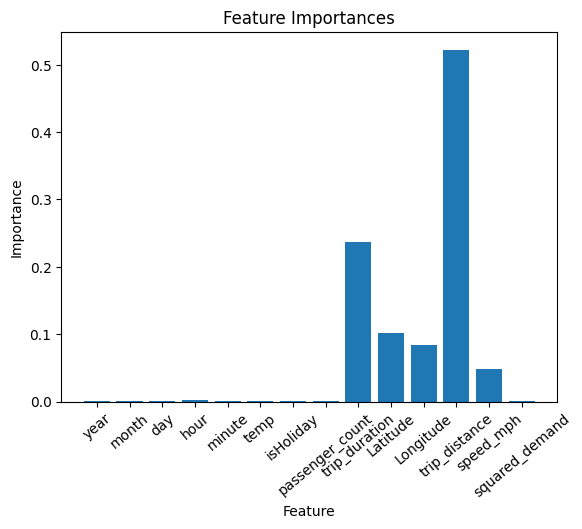

In [0]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt

feature_list = ["year","month","day","hour","minute",'temp','isHoliday',"passenger_count" ,'trip_duration', 'Latitude',"Longitude", "trip_distance","speed_mph","squared_demand"]
assembler = VectorAssembler(
    inputCols=feature_list,
    outputCol='features'
)
rf = RandomForestRegressor(featuresCol='features', labelCol='total_amount')
pipeline = Pipeline(stages = [assembler, rf])
paramGrid = (ParamGridBuilder() 
    .addGrid(rf.numTrees, [10, 20]) 
    .addGrid(rf.maxDepth, [5, 10]) 
    .build())
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="r2")
crossval = CrossValidator(estimator = pipeline, estimatorParamMaps = paramGrid, evaluator = evaluator, numFolds = 3)
(trainingData, testData) = data_ml.randomSplit([0.8, 0.2])
cvModel = crossval.fit(trainingData)
predictions = cvModel.transform(testData)

rf_r2 = evaluator.evaluate(predictions)
print(f"Random Forest R^2: {rf_r2}")

display(rf_r2)
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

Saving model to Azure

In [0]:
%scala
spark.sparkContext.hadoopConfiguration.set(
  "fs.azure.account.key.bia678.blob.core.windows.net",
  "add_your_key_here"
)

In [0]:
# rf_model.save(f"wasb://{container_name}@{storage_account_name}.blob.core.windows.net/pavan-bucket/rf_hyper/")

**Scaling**

2 Workers with 100% data

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

assembler = VectorAssembler(
    inputCols=["year","month","day","hour","minute",'temp','isHoliday',"passenger_count" ,'trip_duration', 'Latitude',"Longitude", "trip_distance","speed_mph","demand_category","squared_demand"],
    outputCol='features'
)

data_ml = assembler.transform(data_ml)


train_data, test_data = data_ml.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol='features', labelCol='total_amount')
rf = RandomForestRegressor(featuresCol='features', labelCol='total_amount',maxDepth=10,numTrees=20)
lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='r2')
evaluator_2 = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='rmse')
lr_r2 = evaluator.evaluate(lr_predictions)
rf_r2 = evaluator.evaluate(rf_predictions)
print(f"Linear Regression R^2: {lr_r2}")
print(f"Random Forest R^2: {rf_r2}")
lr_rmse=evaluator_2.evaluate(lr_predictions)
rf_rmse = evaluator_2.evaluate(rf_predictions)
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")

Linear Regression R^2: 0.9199944411463497
Random Forest R^2: 0.9199471360002306
Linear Regression RMSE: 3.831302797393211
Random Forest RMSE: 3.8324353034248535


3 Workers with 100% data

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

assembler = VectorAssembler(
    inputCols=["year","month","day","hour","minute",'temp','isHoliday',"passenger_count" ,'trip_duration', 'Latitude',"Longitude", "trip_distance","speed_mph","demand_category","squared_demand"],
    outputCol='features'
)

data_ml = assembler.transform(data_ml)


train_data, test_data = data_ml.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol='features', labelCol='total_amount')
rf = RandomForestRegressor(featuresCol='features', labelCol='total_amount',maxDepth=10,numTrees=20)
lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='r2')
evaluator_2 = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='rmse')
lr_r2 = evaluator.evaluate(lr_predictions)
rf_r2 = evaluator.evaluate(rf_predictions)
print(f"Linear Regression R^2: {lr_r2}")
print(f"Random Forest R^2: {rf_r2}")
lr_rmse=evaluator_2.evaluate(lr_predictions)
rf_rmse = evaluator_2.evaluate(rf_predictions)
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")

Linear Regression R^2: 0.9199944411463495
Random Forest R^2: 0.9199471411903842
Linear Regression RMSE: 3.8313027973932114
Random Forest RMSE: 3.832435179188646


4 Workers with 100% data

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

assembler = VectorAssembler(
    inputCols=["year","month","day","hour","minute",'temp','isHoliday',"passenger_count" ,'trip_duration', 'Latitude',"Longitude", "trip_distance","speed_mph","demand_category","squared_demand"],
    outputCol='features'
)

data_ml = assembler.transform(data_ml)


train_data, test_data = data_ml.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol='features', labelCol='total_amount')
rf = RandomForestRegressor(featuresCol='features', labelCol='total_amount',maxDepth=10,numTrees=20)
lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='r2')
evaluator_2 = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='rmse')
lr_r2 = evaluator.evaluate(lr_predictions)
rf_r2 = evaluator.evaluate(rf_predictions)
print(f"Linear Regression R^2: {lr_r2}")
print(f"Random Forest R^2: {rf_r2}")
lr_rmse=evaluator_2.evaluate(lr_predictions)
rf_rmse = evaluator_2.evaluate(rf_predictions)
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")

Linear Regression R^2: 0.9199944411463482
Random Forest R^2: 0.9199471390585762
Linear Regression RMSE: 3.831302797393243
Random Forest RMSE: 3.8324352302175306


In [0]:
from pyspark.sql import SparkSession


schema = StructType([
    StructField("Workers", IntegerType(), True),
    StructField("Time_Minutes", DoubleType(), True),
    StructField("Linear_Regression_R2", DoubleType(), True),
    StructField("Random_Forest_R2", DoubleType(), True)
])

data = [
    (2, 1.48 * 60, 0.9199944411463497, 0.9199471360002306),
    (3, 1.07 * 60, 0.9199944411463495, 0.9199471411903842),
    (4, 0.874 * 60, 0.9199944411463482, 0.9199471390585762)
]
df = spark.createDataFrame(data, schema=schema)
df.createOrReplaceTempView("workers_data")


In [0]:
%sql
SELECT Workers, Time_Minutes FROM workers_data

Workers Time_Minutes 2 88.8 3 64.2 4 52.44

Databricks visualization. Run in Databricks to view.

In [0]:
%sql
SELECT Workers, Linear_Regression_R2, Random_Forest_R2 FROM workers_data


Workers Linear_Regression_R2 Random_Forest_R2 2 0.9199944411463497 0.9199471360002306 3 0.9199944411463495 0.9199471411903842 4 0.9199944411463482 0.9199471390585762

Databricks visualization. Run in Databricks to view.

**Scaling up**

25% of data with 4 workers and 1 driver

In [0]:
totaldata = data_ml.count()
twenty_five = int(totaldata * 0.25)
print(twenty_five)

In [0]:
percent = 0.25
data_ml_sample = data_ml.sample(False,percent)

In [0]:
data_ml_sample.show()

+----+-----+---+----+------+------------+----+---------+-------------+-------------+---------------+----------+-----------+---------+---------------+--------------+
|year|month|day|hour|minute|total_amount|temp|isHoliday|trip_duration|trip_distance|passenger_count|  Latitude|  Longitude|speed_mph|demand_category|squared_demand|
+----+-----+---+----+------+------------+----+---------+-------------+-------------+---------------+----------+-----------+---------+---------------+--------------+
|2021|    7| 15|   9|    25|        74.3|78.3|        0|        46.58|         16.9|            1.0|40.6895314|-74.1744624|    21.77|              1|           1.0|
|2021|   11| 28|  16|    34|       90.05|41.0|        1|        78.97|        13.77|            1.0|40.6895314|-74.1744624|    10.46|              1|           1.0|
|2022|    4| 14|  14|    21|       69.05|81.6|        0|        26.95|        13.74|            2.0|40.6895314|-74.1744624|    30.59|              1|           1.0|
|2022|    

In [0]:
percent = 0.25
total_records = data_ml.count()
data_ml_sample_25 = data_ml.limit(int(total_records * percent))

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

assembler = VectorAssembler(
    inputCols=["year","month","day","hour","minute",'temp','isHoliday',"passenger_count" ,'trip_duration', 'Latitude',"Longitude", "trip_distance","speed_mph","demand_category","squared_demand"],
    outputCol='features'
)

data_ml_sample_25 = assembler.transform(data_ml_sample_25)
train_data, test_data = data_ml_sample_25.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol='features', labelCol='total_amount')
rf = RandomForestRegressor(featuresCol='features', labelCol='total_amount',maxDepth=10,numTrees=20)
lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='r2')
evaluator_2 = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='rmse')
lr_r2 = evaluator.evaluate(lr_predictions)
rf_r2 = evaluator.evaluate(rf_predictions)
print(f"Linear Regression R^2: {lr_r2}")
print(f"Random Forest R^2: {rf_r2}")
lr_rmse=evaluator_2.evaluate(lr_predictions)
rf_rmse = evaluator_2.evaluate(rf_predictions)
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")

Linear Regression R^2: 0.9213905664256661
Random Forest R^2: 0.9301000969807838
Linear Regression RMSE: 3.8628256203575178
Random Forest RMSE: 3.6541200236163736


50 percent of the data with 4 workers and 1 driver

In [0]:
percent = 0.5
total_records = data_ml.count()
data_ml_sample_50 = data_ml.limit(int(total_records * percent))

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

assembler = VectorAssembler(
    inputCols=["year","month","day","hour","minute",'temp','isHoliday',"passenger_count" ,'trip_duration', 'Latitude',"Longitude", "trip_distance","speed_mph","demand_category","squared_demand"],
    outputCol='features'
)

data_ml_sample_50 = assembler.transform(data_ml_sample_50)
train_data, test_data = data_ml_sample_50.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol='features', labelCol='total_amount')
rf = RandomForestRegressor(featuresCol='features', labelCol='total_amount',maxDepth=10,numTrees=20)
lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='r2')
evaluator_2 = RegressionEvaluator(labelCol='total_amount', predictionCol='prediction', metricName='rmse')
lr_r2 = evaluator.evaluate(lr_predictions)
rf_r2 = evaluator.evaluate(rf_predictions)
print(f"Linear Regression R^2: {lr_r2}")
print(f"Random Forest R^2: {rf_r2}")
lr_rmse=evaluator_2.evaluate(lr_predictions)
rf_rmse = evaluator_2.evaluate(rf_predictions)
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")

Linear Regression R^2: 0.9199021723800136
Random Forest R^2: 0.9296063695070713
Linear Regression RMSE: 3.845726491427964
Random Forest RMSE: 3.640762243298417
